<a href="https://colab.research.google.com/github/sn1218/Transactions_Fraud_Detection/blob/main/Online_Payment_Fraud_Detection_Using_Machine_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Online Payment Fraud Detection Using Machine Learning
### <i>By Sum-Ye</i>

## Imports

In [1]:
! pip install hdbscan

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 17.1 MB/s eta 0:00:00


In [2]:
# for data analytics
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# for working with files
from google.colab import files

# for modelling
from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import hdbscan
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import NearestNeighbors

## Source Data

In [ ]:
# install kaggle API client
#! pip install -q kaggle

In [ ]:
# upload token downloaded from kaggle in order to connect to the kaggle API
files.upload()

In [4]:
# make directory called kaggle
! mkdir ~/.kaggle
# move kaggle.json file into new directory
! cp kaggle.json ~/.kaggle/
# set permissions
! chmod 600 ~/.kaggle/kaggle.json

In [5]:
# download dataset
! kaggle datasets download rupakroy/online-payments-fraud-detection-dataset
# unzip the folder
! unzip online-payments-fraud-detection-dataset
# remove the zipped file
! rm -r online-payments-fraud-detection-dataset.zip

Dataset URL: https://www.kaggle.com/datasets/rupakroy/online-payments-fraud-detection-dataset
License(s): CC-BY-NC-SA-4.0
 91% 162M/178M [00:01<00:00, 105MB/s]
100% 178M/178M [00:01<00:00, 114MB/s]
Archive:  online-payments-fraud-detection-dataset.zip
  inflating: PS_20174392719_1491204439457_log.csv  


In [17]:
f = '/content/PS_20174392719_1491204439457_log.csv'
df = pd.read_csv(f)

**About the dataset:**
* **step:** represents a unit of time where 1 step equals 1 hour
* **type:** type of online transaction
* **amount:** the amount of the transaction
* **nameOrig:** customer starting the transaction
* **oldbalanceOrg:** balance before the transaction
* **newbalanceOrig:** balance after the transaction
* **nameDest:** recipient of the transaction
* **oldbalanceDest:** initial balance of recipient before the transaction
* **newbalanceDest:** the new balance of recipient after the transaction
* **isFraud:** fraud transaction

## Initial Check of General Properties

In [ ]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [ ]:
df.tail()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
6362615,743,CASH_OUT,339682.13,C786484425,339682.13,0.0,C776919290,0.00,339682.13,1,0
6362616,743,TRANSFER,6311409.28,C1529008245,6311409.28,0.0,C1881841831,0.00,0.00,1,0
6362617,743,CASH_OUT,6311409.28,C1162922333,6311409.28,0.0,C1365125890,68488.84,6379898.11,1,0
6362618,743,TRANSFER,850002.52,C1685995037,850002.52,0.0,C2080388513,0.00,0.00,1,0
6362619,743,CASH_OUT,850002.52,C1280323807,850002.52,0.0,C873221189,6510099.11,7360101.63,1,0


In [ ]:
df.shape

(6362620, 11)

In [ ]:
df.columns

Index(['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud'],
      dtype='object')

In [ ]:
df.dtypes

,0
step,int64
type,object
amount,float64
nameOrig,object
oldbalanceOrg,float64
newbalanceOrig,float64
nameDest,object
oldbalanceDest,float64
newbalanceDest,float64
isFraud,int64


## Data Cleaning

In [ ]:
# check for missing data
df.isnull().sum()

,0
step,0
type,0
amount,0
nameOrig,0
oldbalanceOrg,0
newbalanceOrig,0
nameDest,0
oldbalanceDest,0
newbalanceDest,0
isFraud,0


In [ ]:
# check for duplicate rows
df.duplicated().sum()

0

In [ ]:
# check unique values
df.nunique()

,0
step,743
type,5
amount,5316900
nameOrig,6353307
oldbalanceOrg,1845844
newbalanceOrig,2682586
nameDest,2722362
oldbalanceDest,3614697
newbalanceDest,3555499
isFraud,2


## Exploratory Data Analysis

In [ ]:
# check summary statistics
df.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


In [ ]:
# check the categories in 'type'
df['type'].unique()

array(['PAYMENT', 'TRANSFER', 'CASH_OUT', 'DEBIT', 'CASH_IN'],
      dtype=object)

In [ ]:
# look at the proportion of the different types
df['type'].value_counts(normalize=True)

,proportion
type,
CASH_OUT,0.351663
PAYMENT,0.338146
CASH_IN,0.219923
TRANSFER,0.083756
DEBIT,0.006512


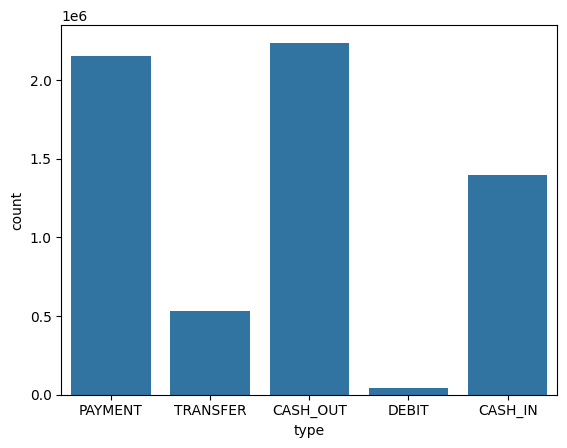

In [ ]:
# show proportion of types in a graph
sns.countplot(data=df, x='type')
plt.show()

**Insights:**
> * There are five transaction types: payment, transfer, cash outm debit and cash in.
* Payment and cash out are the most popular type of transaction type.

### Focused on Fraudulent Transactions

In [ ]:
df['isFraud'].value_counts(normalize=True)
# majority (>99%) is not fraud, so will have to sample later

,proportion
isFraud,
0,0.998709
1,0.001291


**Insights:**
> * The majority (>99%) of transactions in this dataset are non-fraudulent, which is a massive class imbalance.

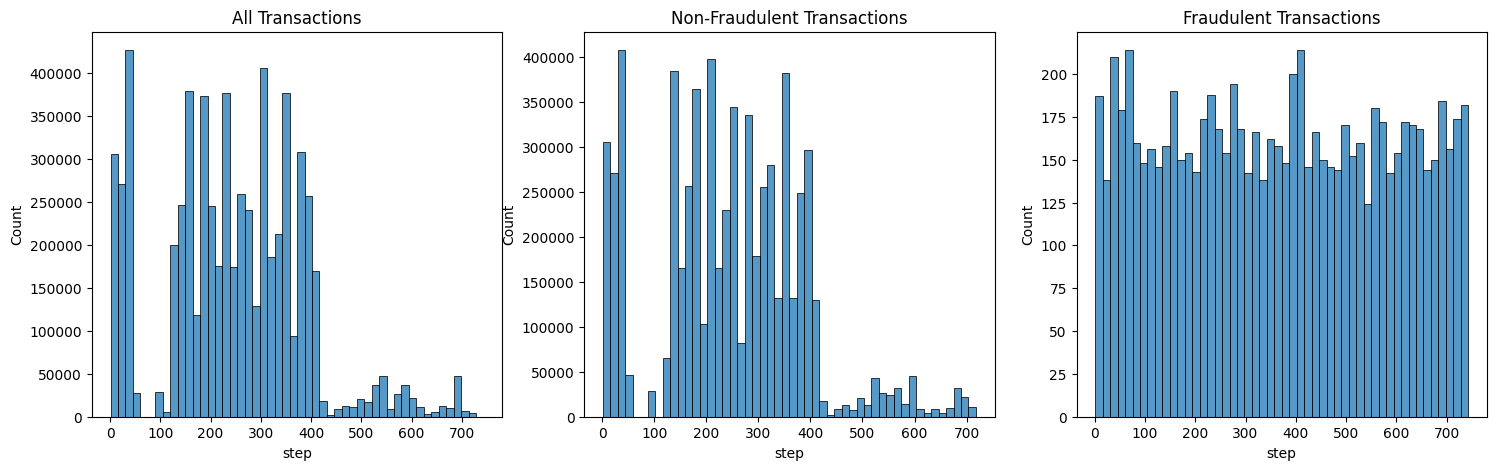

In [ ]:
# create subplots
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

# plot countplots for all transactions, non-fraudulent transactions, and fraudulent transactions
sns.histplot(df['step'], bins=50, ax=axs[0])
axs[0].set_title('All Transactions')

sns.histplot(df[df['isFraud'] == 0]['step'], bins=50, ax=axs[1])
axs[1].set_title('Non-Fraudulent Transactions')

sns.histplot(df[df['isFraud'] == 1]['step'], bins=50, ax=axs[2])
axs[2].set_title('Fraudulent Transactions')

plt.show()

In [ ]:
# calculate the max and average amount at each step
avg_amount_all = df.groupby('step')['amount'].mean()
max_amount_all = df.groupby('step')['amount'].max()

avg_amount_non_fraud = df[df['isFraud'] == 0].groupby('step')['amount'].mean()
max_amount_non_fraud = df[df['isFraud'] == 0].groupby('step')['amount'].max()

avg_amount_fraud = df[df['isFraud'] == 1].groupby('step')['amount'].mean()
max_amount_fraud = df[df['isFraud'] == 1].groupby('step')['amount'].max()

# determine the global y-axis limits
all_avg_amounts = [avg_amount_all, avg_amount_non_fraud, avg_amount_fraud]
all_max_amounts = [max_amount_all, max_amount_non_fraud, max_amount_fraud]
all_y_values = np.concatenate([avg.values for avg in all_avg_amounts] + [max.values for max in all_max_amounts])
y_min, y_max = all_y_values.min(), all_y_values.max()

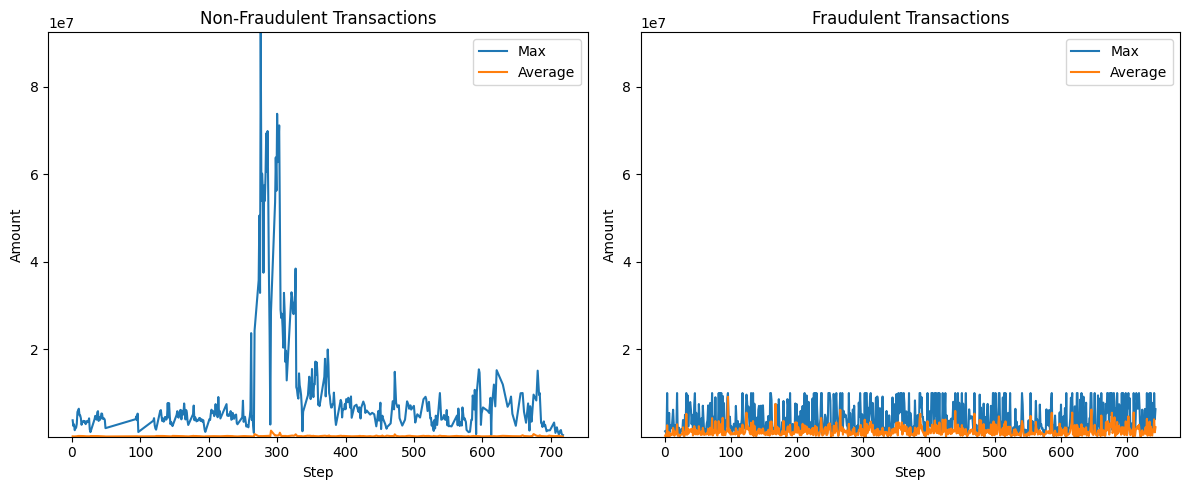

In [ ]:
# create subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 5))  # Adjusted figsize for better appearance

sns.lineplot(x=max_amount_non_fraud.index, y=max_amount_non_fraud.values, label='Max', ax=axs[0])
sns.lineplot(x=avg_amount_non_fraud.index, y=avg_amount_non_fraud.values, label='Average', ax=axs[0])
axs[0].set_title('Non-Fraudulent Transactions')

sns.lineplot(x=max_amount_fraud.index, y=max_amount_fraud.values, label='Max', ax=axs[1])
sns.lineplot(x=avg_amount_fraud.index, y=avg_amount_fraud.values, label='Average', ax=axs[1])
axs[1].set_title('Fraudulent Transactions')
axs[1].legend()

# set labels for axes
for ax in axs:
    ax.set_ylim(y_min, y_max)
    ax.set_xlabel('Step')
    ax.set_ylabel('Amount')

# adjust layout and show the plot
plt.tight_layout()
plt.show()

In [ ]:
# check maximum amount for fradulent transactions
df[df['isFraud']==1]['amount'].max()

10000000.0

In [ ]:
# check maximum amount for non-fraudulent transactions
df[df['isFraud']==0]['amount'].max()

92445516.64

**Insights:**
> * The maximum for non-fraudulent transactions far outstrips the maximum for fraudulent transactions.
* This dataset is likely synthetic as there seems to be a ceiling for the maximum amount for fraudulent transactions (\$10,000,000).
* A greedy machine learning model such as linear regression or logistic regression may not be best here as the model may capitalise on the fact that in this dataset fraudulent transactions are capped at \$10,000,000, but real-world fraudulent transactions are not capped.

In [ ]:
# check type of transactions where the transaction is fraudulent
df[df['isFraud']==1]['type'].value_counts(normalize=True)

,proportion
type,
CASH_OUT,0.501157
TRANSFER,0.498843


<Axes: xlabel='type', ylabel='amount'>

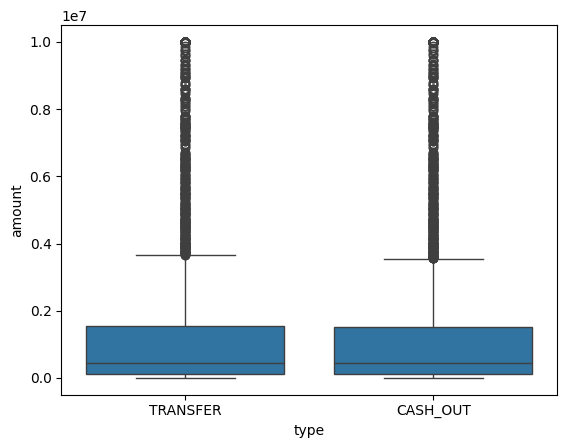

In [ ]:
sns.boxplot(data=df[df['isFraud']==1], x='type', y='amount')

**Insights:**
> * Fraudulent payments are either cash out or transfer.

In [ ]:
# check summary stats for fraudulent transactions
df[df['isFraud']==1].describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,8213.000000,8.213000e+03,8.213000e+03,8.213000e+03,8.213000e+03,8.213000e+03,8213.0,8213.000000
mean,368.413856,1.467967e+06,1.649668e+06,1.923926e+05,5.442496e+05,1.279708e+06,1.0,0.001948
std,216.388690,2.404253e+06,3.547719e+06,1.965666e+06,3.336421e+06,3.908817e+06,0.0,0.044097
min,1.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.0,0.000000
25%,181.000000,1.270913e+05,1.258224e+05,0.000000e+00,0.000000e+00,0.000000e+00,1.0,0.000000
50%,367.000000,4.414234e+05,4.389835e+05,0.000000e+00,0.000000e+00,4.676420e+03,1.0,0.000000
75%,558.000000,1.517771e+06,1.517771e+06,0.000000e+00,1.478287e+05,1.058725e+06,1.0,0.000000
max,743.000000,1.000000e+07,5.958504e+07,4.958504e+07,2.362305e+08,2.367265e+08,1.0,1.000000


In [ ]:
# check if fraudulent data has been flagged
df[df['isFraud']==1]['isFlaggedFraud'].value_counts()

,count
isFlaggedFraud,
0,8197
1,16


In [ ]:
# check if any non-fraudulent data has been flagged as fraud
df[df['isFraud']==0]['isFlaggedFraud'].value_counts()

,count
isFlaggedFraud,
0,6354407


**Insights:**
> * Of the 8213 transactions that were fraudulent, only 16 of them were actually flagged as fraud (<1%).
* None of the non-fraudulent transactions were flagged.

In [ ]:
# check the first letters of nameDest
df['nameDest_first_letter'] = df['nameDest'].str[0]
print(df['nameDest_first_letter'].unique())

['M' 'C']


In [ ]:
# look at the proportion of M and C
df['nameDest_first_letter'].value_counts(normalize=True)

,proportion
nameDest_first_letter,
C,0.661854
M,0.338146


In [ ]:
# check the first letters of nameOrig
df['nameOrig_first_letter'] = df['nameOrig'].str[0]
print(df['nameOrig_first_letter'].unique())

['C']


In [ ]:
# look at the value count
df[df['isFraud']==1]['nameDest_first_letter'].value_counts()

,count
nameDest_first_letter,
C,8213


**Insights:**
**Insights:**
> * It is not said in the metadata what 'M' and 'C' stand for, but in the context of financial transactions, they might represent a merchant account or a customer account.
* Within the data as a whole, it seems all transcations originate from customer accounts, with transactions to other customers, e.g. peer-to-peer, making up two-thirds of the transactions, and commercial transactions making up the rest.
* All fraudulent activity seems to be between customer accounts.

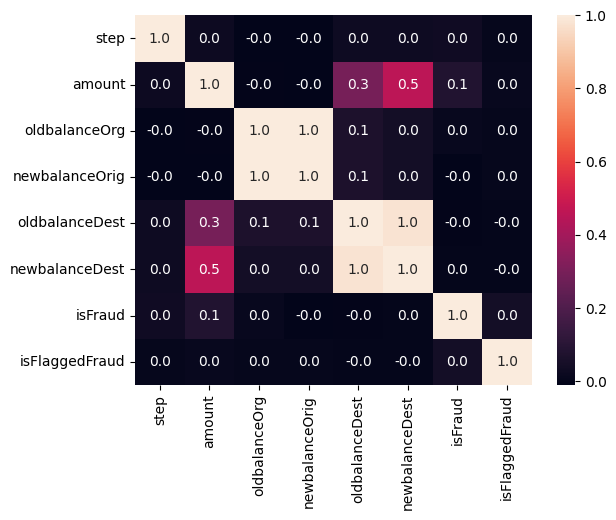

In [ ]:
# check for correlation between columns
sns.heatmap(data=df.corr(numeric_only=True),
            annot=True,
            fmt=".1f")
plt.show()

**Insights:**
> * There is strong correlation betwen oldbalanceOrig and newbalanceOrig, and oldbalanceDesst and newblaanceDest, as expected.
* There is some correlation between newbalanceDest and the amount.

In [ ]:
cust_trans_counts = df['nameOrig'].value_counts()

# filter customers who have more than one transaction
duplicated_cust = cust_trans_counts[cust_trans_counts > 1]

# number of customers with duplicated transactions
print(f"Number of customers with more than one transaction: {len(duplicated_cust)}")

# show the first few customers with duplicated transactions
duplicated_cust.head()

Number of customers with more than one transaction: 9298


,count
nameOrig,
C1902386530,3
C363736674,3
C545315117,3
C724452879,3
C1784010646,3


In [ ]:
rec_trans_counts = df['nameDest'].value_counts()

# filter recipients who have recieved more than one payment
duplicated_rec = rec_trans_counts[rec_trans_counts > 1]

# number of customers with duplicated transactions
print(f"Number of recipients who have recieved more than one payment: {len(duplicated_rec)}")

# show the first few customers with duplicated transactions
duplicated_rec.head()

Number of recipients who have recieved more than one payment: 459658


,count
nameDest,
C1286084959,113
C985934102,109
C665576141,105
C2083562754,102
C248609774,101


**Insights:**
> * Customers that have more than 1 outgoing transaction (over a 30 day period) are rare (<1%).
* Recipients that have recieved more than 1 payment are also rare (7%).

## Deciding on a model

(See EDA section)

*   Considering that fraud rarely has a simple pattern, the large class imbalance, and the synthetic cap of $10,000,000 on fraudulent transactions, greedy models such as linear or logistic regression are not well suited.
*   Hidden Markov Models (HMM) may be of limited use as they require sequential data to identify anomalies, and customers that have more than 1 outgoing transaction in this dataset are rare; recipients that have received more than one payment are also rare.
* We will look at isolation forests to identify anomalies, and at HDBSCANs. We can use these unsupervised methods, but still compare our results to the labels we have (fraud or not) to see how the models did.



## Feature Engineering

In [ ]:
def prepare_features(df):

  # find the relative time in hours and day of the week (we don't know the absolute time that step starts at)
  df['hour'] = df['step'] % 24
  df['day_of_week'] = df['step'] % 7

  # how large is the transaction relative to the sender's available balance - fraudulent activities might exhibit large ratios
  df['amount_to_oldbalance_ratio'] = df['amount'] / (df['oldbalanceOrg'] + 1e-5)  # to avoid division by zero

  # how much of the sender's balance is left after the transaction - draining the account might be indicative of fraud
  df['remaining_balance_ratio'] = df['newbalanceOrig'] / (df['oldbalanceOrg'] + 1e-5)

  # how large is the transaction relative to the recipient's inital balance - fraudulent transactions may involve sending large amounts to accounts with little to no initial balance.
  df['amount_to_dest_balance_ratio'] = df['amount'] / (df['oldbalanceDest'] + 1e-5)

  #  net change in the sender’s balance after the transaction
  df['balance_change'] = df['newbalanceOrig'] - df['oldbalanceOrg']

  # net change for the recipient
  df['rec_balance_change'] = df['newbalanceDest'] - df['oldbalanceDest']

  # find time since last transaction
  # replace nulls (for first transactions) with large values because filling with 0 indicates no time gap between transactions which could distort clustering
  df['time_since_last_transaction_cust'] = df.groupby('nameOrig')['step'].diff().fillna(df['step'].max())
  df['time_since_last_transaction_rec'] = df.groupby('nameDest')['step'].diff().fillna(df['step'].max())

  # one-hot encode type category
  df = pd.get_dummies(df, columns=['type'])

  # sent to merchant or not
  df['is_merchant'] = df['nameDest'].apply(lambda x: 1 if x[0] == 'M' else 0)

  return df

In [ ]:
df = prepare_features(df)

In [ ]:
df.head()

,step,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,...,type_PAYMENT,type_TRANSFER,is_merchant,same_amount_prev,same_amount_rec_prev,cust_rec_freq,cust_amount_vs_median,rec_amount_vs_median,customer_trans_count,recipient_trans_count
0,1,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0,...,True,False,1,False,False,1,1.0,1.000000,1,1
1,1,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0,...,True,False,1,False,False,1,1.0,1.000000,1,1
2,1,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0,...,False,True,0,False,False,1,1.0,0.001299,1,44
3,1,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0,...,False,False,0,False,False,1,1.0,0.000942,1,41
4,1,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0,...,True,False,1,False,False,1,1.0,1.000000,1,1


## Modelling

### Isolation forest

In [ ]:
features = [
    'hour',
    'day_of_week',
    'amount',
    'amount_to_oldbalance_ratio',
    'remaining_balance_ratio',
    'amount_to_dest_balance_ratio',
    'balance_change',
    'time_since_last_transaction_cust', 'time_since_last_transaction_rec',
    'type_CASH_IN', 'type_CASH_OUT', 'type_DEBIT', 'type_PAYMENT', 'type_TRANSFER',
    'is_merchant'
]

In [ ]:
# scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[features])

In [ ]:
iso_forest = IsolationForest(n_estimators=300,  # number of trees
                             #max_samples=0.8,
                             contamination=0.01,  # approximate percentage of anomalies
                             random_state=42)

# fit the isolation forest model on the dataset
iso_forest.fit(X_scaled)

# predict anomalies (fraudulent transactions)
df['anomaly_score'] = iso_forest.decision_function(X_scaled) # returns anomaly scores, where negative values indicate anomalies, and higher values indicate normal points.
df['is_anomaly'] = iso_forest.predict(X_scaled) # returns -1 for anomalies and 1 for normal transcations

In [ ]:
# anomalies are labeled as -1, and normal points as 1
df['is_fraud_prediction'] = np.where(df['is_anomaly'] == -1, 1, 0)

# count of predicted frauds (anomalies)
print(df['is_fraud_prediction'].value_counts())

# filter the detected fraudulent transactions
fraud_transactions = df[df['is_fraud_prediction'] == 1]
print(fraud_transactions.head())

is_fraud_prediction
0    6298993
1      63627
Name: count, dtype: int64
     step      amount     nameOrig  oldbalanceOrg  newbalanceOrig  \
85      1  1505626.01   C926859124            0.0             0.0   
359     1  2421578.09   C106297322            0.0             0.0   
375     1  2545478.01  C1057507014            0.0             0.0   
376     1  2061082.82  C2007599722            0.0             0.0   
797     1  1867849.02   C355885103            0.0             0.0   

        nameDest  oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud  \
85    C665576141        29031.00      5515763.34        0               0   
359  C1590550415      8515645.77     19169204.93        0               0   
375  C1590550415     12394437.40     19169204.93        0               0   
376  C1590550415     14939915.42     19169204.93        0               0   
797   C665576141      2271538.11      5515763.34        0               0   

     ...  time_since_last_transaction_rec  type_CA

In [ ]:
# model using 300 trees
# confusion matrix
print(confusion_matrix(df['isFraud'], df['is_fraud_prediction']))

# classification report
print(classification_report(df['isFraud'], df['is_fraud_prediction']))

[[6294384   60023]
 [   4609    3604]]
              precision    recall  f1-score   support

           0       1.00      0.99      0.99   6354407
           1       0.06      0.44      0.10      8213

    accuracy                           0.99   6362620
   macro avg       0.53      0.71      0.55   6362620
weighted avg       1.00      0.99      0.99   6362620



In [ ]:
iso_forest = IsolationForest(n_estimators=400,  # number of trees
                             #max_samples=0.8,
                             contamination=0.01,  # approximate percentage of anomalies
                             random_state=42)

# fit the isolation forest model on the dataset
iso_forest.fit(X_scaled)

# predict anomalies (fraudulent transactions)
df['anomaly_score'] = iso_forest.decision_function(X_scaled) # returns anomaly scores, where negative values indicate anomalies, and higher values indicate normal points.
df['is_anomaly'] = iso_forest.predict(X_scaled) # returns -1 for anomalies and 1 for normal transcations

In [ ]:
# anomalies are labeled as -1, and normal points as 1
df['is_fraud_prediction'] = np.where(df['is_anomaly'] == -1, 1, 0)

# count of predicted frauds (anomalies)
print(df['is_fraud_prediction'].value_counts())

# filter the detected fraudulent transactions
fraud_transactions = df[df['is_fraud_prediction'] == 1]
print(fraud_transactions.head())

is_fraud_prediction
0    6298994
1      63626
Name: count, dtype: int64
     step      amount     nameOrig  oldbalanceOrg  newbalanceOrig  \
85      1  1505626.01   C926859124            0.0             0.0   
94      1  1724887.05  C1495608502            0.0             0.0   
359     1  2421578.09   C106297322            0.0             0.0   
375     1  2545478.01  C1057507014            0.0             0.0   
376     1  2061082.82  C2007599722            0.0             0.0   

        nameDest  oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud  \
85    C665576141        29031.00      5515763.34        0               0   
94   C1590550415      3470595.10     19169204.93        0               0   
359  C1590550415      8515645.77     19169204.93        0               0   
375  C1590550415     12394437.40     19169204.93        0               0   
376  C1590550415     14939915.42     19169204.93        0               0   

     ...  time_since_last_transaction_rec  type_CA

In [ ]:
# model using 400 trees
# confusion matrix
print(confusion_matrix(df['isFraud'], df['is_fraud_prediction']))

# classification report
print(classification_report(df['isFraud'], df['is_fraud_prediction']))

[[6294184   60223]
 [   4810    3403]]
              precision    recall  f1-score   support

           0       1.00      0.99      0.99   6354407
           1       0.05      0.41      0.09      8213

    accuracy                           0.99   6362620
   macro avg       0.53      0.70      0.54   6362620
weighted avg       1.00      0.99      0.99   6362620



Using isolation forests did not give a good recall or precision. Let's try a HDBSCAN.

### HDBSCAN

This model initially used the whole dataset, however the model would run for hours and still not complete, therefore a sample of 10% was taken instead for the sake of time.

In [18]:
# make a dataset of just fraudulent data, and just non-fraudulent data for stratified sampling
df_fraud = df[df['isFraud'] == 1]
df_non_fraud = df[df['isFraud'] == 0]
print(len(df_fraud), len(df_non_fraud))

8213 6354407


In [19]:
# sample 10% from each dataset
df_non_fraud_sample = df_non_fraud.sample(n=635440, random_state=42)
df_fraud_sample = df_fraud.sample(n=821, random_state=42)

In [20]:
# combine fraud and subsampled non-fraud cases
df_sampled = pd.concat([df_fraud_sample, df_non_fraud_sample])

In [21]:
df_sampled.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
6266285,615,TRANSFER,56510.50,C956959892,56510.50,0.00,C582952352,0.0,0.00,1,0
6358608,714,TRANSFER,10000000.00,C131412689,10390763.24,390763.24,C1846567377,0.0,0.00,1,0
4472587,324,TRANSFER,21580.37,C765450059,21580.37,0.00,C125935569,0.0,0.00,1,0
6293769,668,CASH_OUT,1576531.53,C2000069930,1576531.53,0.00,C1345448010,0.0,1576531.53,1,0
6055691,499,TRANSFER,488243.65,C2117568077,488243.65,0.00,C1238599279,0.0,0.00,1,0


In [ ]:
features = [
    'hour',
    'day_of_week',
    'amount',
    'amount_to_oldbalance_ratio',
    'remaining_balance_ratio',
    'amount_to_dest_balance_ratio',
    'balance_change', 'rec_balance_change',
    'time_since_last_transaction_cust', 'time_since_last_transaction_rec',
    'type_CASH_IN', 'type_CASH_OUT', 'type_DEBIT', 'type_PAYMENT', 'type_TRANSFER',
    'is_merchant'
]

In [ ]:
# scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_sampled[features])

# reduce the dimensions of the data to run the model faster
pca = PCA(n_components=4)
reduced_data = pca.fit_transform(X_scaled)

In [ ]:
# cluster the data using HDBSCAN
clusterer = hdbscan.HDBSCAN(min_samples=10, min_cluster_size=10, prediction_data=True, approx_min_span_tree=True)
cluster_labels = clusterer.fit_predict(reduced_data)

In [ ]:
print(cluster_labels)
n_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
print(f'Number of clusters found: {n_clusters}')
n_noise = list(cluster_labels).count(-1)
print(f'Number of noise points: {n_noise}')
unique, counts = np.unique(cluster_labels, return_counts=True)
cluster_counts = dict(zip(unique, counts))
print(f'Cluster sizes: {cluster_counts}')

[62  0 62 ... 26 51 54]
Number of clusters found: 6212
Number of noise points: 158770
Cluster sizes: {-1: 158770, 0: 28, 1: 21, 2: 13, 3: 55, 4: 12, 5: 14, 6: 14, 7: 95, 8: 11, 9: 12, 10: 12, 11: 25, 12: 11, 13: 12, 14: 21, 15: 12, 16: 25, 17: 22, 18: 11, 19: 61, 20: 18, 21: 37, 22: 15, 23: 15, 24: 12, 25: 29, 26: 17339, 27: 23, 28: 13, 29: 17, 30: 25, 31: 14, 32: 21, 33: 15, 34: 12, 35: 39, 36: 352, 37: 17, 38: 296, 39: 3332, 40: 17, 41: 27, 42: 50, 43: 21, 44: 33, 45: 25, 46: 12, 47: 43, 48: 14, 49: 15, 50: 12, 51: 18, 52: 17, 53: 32356, 54: 190753, 55: 19, 56: 14, 57: 21, 58: 20, 59: 13, 60: 24, 61: 41, 62: 5404, 63: 53, 64: 18, 65: 10, 66: 33, 67: 10, 68: 50, 69: 54, 70: 44823, 71: 14, 72: 16, 73: 32, 74: 12, 75: 28, 76: 12, 77: 14, 78: 10, 79: 11, 80: 29, 81: 17, 82: 13, 83: 14, 84: 13, 85: 31, 86: 13, 87: 10, 88: 27, 89: 78, 90: 21, 91: 25, 92: 110, 93: 10, 94: 15, 95: 53, 96: 12, 97: 27, 98: 18, 99: 14, 100: 17, 101: 17, 102: 21, 103: 51, 104: 41, 105: 20, 106: 25, 107: 26, 108:

In [ ]:
# add cluster labels to the dataframe
df_sampled['cluster'] = cluster_labels

In [ ]:
df_sampled.head()

,step,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,...,rec_balance_change,time_since_last_transaction_cust,time_since_last_transaction_rec,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER,is_merchant,cluster
6266285,615,56510.50,C956959892,56510.50,0.00,C582952352,0.0,0.00,1,0,...,0.00,743.0,743.0,False,False,False,False,True,0,62
6358608,714,10000000.00,C131412689,10390763.24,390763.24,C1846567377,0.0,0.00,1,0,...,0.00,743.0,743.0,False,False,False,False,True,0,0
4472587,324,21580.37,C765450059,21580.37,0.00,C125935569,0.0,0.00,1,0,...,0.00,743.0,743.0,False,False,False,False,True,0,62
6293769,668,1576531.53,C2000069930,1576531.53,0.00,C1345448010,0.0,1576531.53,1,0,...,1576531.53,743.0,743.0,False,True,False,False,False,0,-1
6055691,499,488243.65,C2117568077,488243.65,0.00,C1238599279,0.0,0.00,1,0,...,0.00,743.0,743.0,False,False,False,False,True,0,58


In [ ]:
# further EDA to see which clusters hold the most fraudulent data

cluster_fraud_stats = df_sampled.groupby('cluster').agg(
    total_transactions=('isFraud', 'size'),
    fraudulent_transactions=('isFraud', 'sum')
).reset_index()

# calculate fraud percentage for each cluster
cluster_fraud_stats['fraud_percentage'] = (cluster_fraud_stats['fraudulent_transactions'] /
                                           cluster_fraud_stats['total_transactions']) * 100

# sort by fraud percentage to see the most fraudulent clusters
cluster_fraud_stats = cluster_fraud_stats.sort_values(by='fraud_percentage', ascending=False)

# display the result
print(cluster_fraud_stats)

      cluster  total_transactions  fraudulent_transactions  fraud_percentage
1           0                  28                       28             100.0
18         17                  22                       22             100.0
7           6                  14                       14             100.0
51         50                  12                       12             100.0
9           8                  11                       11             100.0
...       ...                 ...                      ...               ...
2074     2073                  16                        0               0.0
2073     2072                  18                        0               0.0
2072     2071                  16                        0               0.0
2071     2070                  43                        0               0.0
6212     6211                  21                        0               0.0

[6213 rows x 4 columns]


In [ ]:
cluster_fraud_stats.head(60)

,cluster,total_transactions,fraudulent_transactions,fraud_percentage
1,0,28,28,100.000000
18,17,22,22,100.000000
7,6,14,14,100.000000
51,50,12,12,100.000000
9,8,11,11,100.000000
31,30,25,25,100.000000
59,58,20,7,35.000000
63,62,5404,163,3.016284
0,-1,158770,321,0.202179
54,53,32356,49,0.151440


**Insights:**
> * Some clusters are entirely fraudulent.
* Some clusters, such as cluster 62 and -1 could probably be subclustered to further attempt to separate out fraudulent and non-fraudulent.

In [ ]:
# separate noise points from df_sampled
noise_points = df_sampled[df_sampled['cluster'] == -1]

# perform HDBSCAN subclustering on noise points
subclusterer = hdbscan.HDBSCAN(min_samples=5, min_cluster_size=5)  # Adjust as necessary
noise_points['subcluster'] = subclusterer.fit_predict(noise_points[features])  # feature_columns should be your feature set

# assign subcluster labels back into the main dataframe (for noise points only)
df_sampled.loc[df_sampled['cluster'] == -1, 'subcluster'] = noise_points['subcluster']


<ipython-input-22-fdad4a704977>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  noise_points['subcluster'] = subclusterer.fit_predict(noise_points[features])  # feature_columns should be your feature set


In [ ]:
# further EDA to see which subclusters hold the most fraudulent data

# calculate fraud percentage for subclusters of noise
subcluster_fraud_stats = noise_points.groupby('subcluster').agg(
    total_transactions=('subcluster', 'size'),
    fraudulent_transactions=('isFraud', 'sum')
).reset_index()

subcluster_fraud_stats['fraud_percentage'] = (subcluster_fraud_stats['fraudulent_transactions'] /
                                              subcluster_fraud_stats['total_transactions']) * 100

In [ ]:
subcluster_fraud_stats.sort_values(by='fraud_percentage', ascending=False).head(20)

,subcluster,total_transactions,fraudulent_transactions,fraud_percentage
1719,1718,9,9,100.000000
2169,2168,8,8,100.000000
2967,2966,17,16,94.117647
5261,5260,13,12,92.307692
9,8,6,5,83.333333
5273,5272,23,19,82.608696
5279,5278,20,12,60.000000
48,47,7,4,57.142857
5278,5277,11,6,54.545455
21,20,15,8,53.333333


In [ ]:
# separate cluster 62 from df_sampled
cluster_62 = df_sampled[df_sampled['cluster'] == 62]

# count fraudulent transactions
fraud_count = cluster_62['isFraud'].sum()
total_count = cluster_62.shape[0]
fraud_percentage = (fraud_count / total_count) * 100 if total_count > 0 else 0

print("Total transactions in Cluster 62:", total_count)
print("Total fraudulent transactions in Cluster 62:", fraud_count)
print("Fraud percentage in Cluster 62: {:.2f}%".format(fraud_percentage))

Total transactions in Cluster 62: 5404
Total fraudulent transactions in Cluster 62: 163
Fraud percentage in Cluster 62: 3.02%


/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


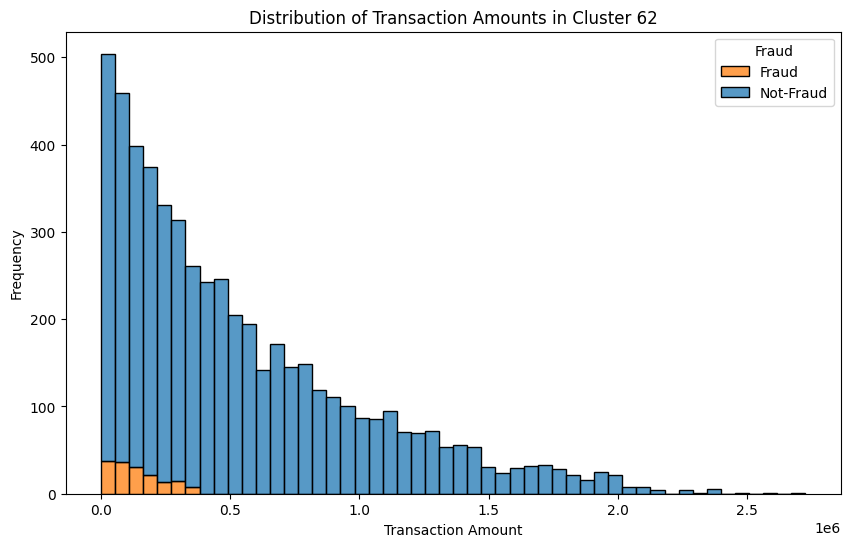

In [ ]:
# look at distribution of transaction amounts in cluster 62
plt.figure(figsize=(10, 6))
sns.histplot(data=cluster_62, x='amount', hue='isFraud', bins=50, multiple="stack")
plt.title('Distribution of Transaction Amounts in Cluster 62')
plt.xlabel('Transaction Amount')
plt.ylabel('Frequency')
plt.legend(title='Fraud', loc='upper right', labels=['Fraud', 'Not-Fraud'])
plt.show()

In [ ]:
# perform HDBSCAN subclustering on cluster 62
subclusterer_62 = hdbscan.HDBSCAN(min_samples=5, min_cluster_size=5)
cluster_62['subcluster'] = subclusterer_62.fit_predict(cluster_62[features])

# assign subcluster labels back into the main dataframe
df_sampled.loc[df_sampled['cluster'] == 62, 'subcluster'] = cluster_62['subcluster']

<ipython-input-27-6ab60e089f0b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_62['subcluster'] = subclusterer_62.fit_predict(cluster_62[features])  # feature_columns should be your feature set


In [ ]:
# further EDA to see which subclusters hold the most fraudulent data

subcluster_62_fraud_stats = cluster_62.groupby('subcluster').agg(
    total_transactions=('subcluster', 'size'),
    fraudulent_transactions=('isFraud', 'sum')
).reset_index()

subcluster_62_fraud_stats['fraud_percentage'] = (subcluster_62_fraud_stats['fraudulent_transactions'] /
                                              subcluster_62_fraud_stats['total_transactions']) * 100

In [ ]:
subcluster_62_fraud_stats.sort_values(by='fraud_percentage', ascending=False).head(20)

,subcluster,total_transactions,fraudulent_transactions,fraud_percentage
128,127,5,3,60.000000
254,253,7,3,42.857143
233,232,7,3,42.857143
242,241,10,4,40.000000
205,204,6,2,33.333333
194,193,9,3,33.333333
240,239,6,2,33.333333
232,231,7,2,28.571429
219,218,8,2,25.000000
137,136,12,3,25.000000


In [ ]:
# define thresholds. Any cluster above this threshold will all be classed as fraud
fraud_threshold = 5  # general clusters
noise_fraud_threshold = 12  # noise subclusters
cluster_62_fraud_percentage_threshold = 12  # cluster 62 subclusters

# determine high-risk clusters based on the general fraud threshold
high_fraud_clusters = cluster_fraud_stats[
    (cluster_fraud_stats['fraud_percentage'] > fraud_threshold)
]['cluster'].values

# determine high-risk subclusters based on the fraud percentage threshold
high_fraud_subclusters_62 = subcluster_62_fraud_stats[
    (subcluster_62_fraud_stats['fraud_percentage'] > cluster_62_fraud_percentage_threshold)
]['subcluster'].values

high_fraud_subclusters = subcluster_fraud_stats[
    (subcluster_fraud_stats['fraud_percentage'] > noise_fraud_threshold)
]['subcluster'].values

# update 'high_fraud_risk' feature based on both high-fraud clusters and high-fraud subclusters
df_sampled['high_fraud_risk'] = df_sampled.apply(
    lambda row: 1 if (row['cluster'] in high_fraud_clusters or
                      (row['cluster'] == 62 and row['subcluster'] in high_fraud_subclusters_62) or
                      (row['cluster'] == -1 and row['subcluster'] in high_fraud_subclusters)) else 0,
    axis=1
)

In [ ]:
# check how our model does

# true labels (actual fraud cases)
y_true = df_sampled['isFraud']

# predicted fraud risk based on clusters
y_pred = df_sampled['high_fraud_risk']

# confusion matrix
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(cm)

# classification report
report = classification_report(y_true, y_pred)
print("Classification Report:")
print(report)

Confusion Matrix:
[[634593    847]
 [   379    442]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    635440
           1       0.34      0.54      0.42       821

    accuracy                           1.00    636261
   macro avg       0.67      0.77      0.71    636261
weighted avg       1.00      1.00      1.00    636261



The recall and precision are not ideal for identifying fraudulent data, but I initially set out with a goal to achieve a recall above 50% and precision above 25%. In that regard, this is a small success, as both metrics were met.

The cluster centroids, the high risk cluster lists, and the df_sampled are saved to pkl files. They are accessed again in the 'Testing Clustering Model on New Data.ipynb' file.

In [ ]:
# calculate cluster centroids
original_cluster_centroids = df_sampled.groupby('cluster')[features].mean()

# do the same for subclusters
original_subcluster_centroids = df_sampled.groupby(['cluster', 'subcluster'])[features].mean()